In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_pow = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/pow_inv-32-A_5min.pkl')
df_POA = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/poa_5min.pkl')
df_Tmod = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/tmod_5min.pkl')
df_met = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/met_5min.pkl')
df_T = df_met[['Temp','Timestamp']]
df_T = df_T.rename(columns={'Temp': 'Temp','Timestamp': 'time'})

df_inner = pd.merge(df_pow, df_POA, on='time', how='inner')
df_inner2 = pd.merge(df_inner, df_Tmod, on='time', how='inner')
df = pd.merge(df_inner2, df_T, on='time', how='inner')

df.set_index('time', inplace=True)
df = df.rename(columns={'power': 'Power','value_x': 'POA','value_y': 'Tmod' })

print(df.shape)
print(df.columns)

(113472, 4)
Index(['Power', 'POA', 'Tmod', 'Temp'], dtype='object')


In [3]:
## Define the morning hour range
#start_hour = 6
#end_hour = 21
## Filter rows based on morning hour range
#df = df[(df.index.hour >= start_hour) & (df.index.hour < end_hour)]
#print(df.shape)

In [4]:
#df = df[df['POA']>0]
#df = df[df['Power']>0]
#print(df.shape)

In [5]:
# Solar panel = JKM345M-72-V x 5742 panels
POA_std = 1000
Capacity = 5742*345/1000000
T_std = 25 
#T_std = df['Tmod'].mean()
alpha = -0.004

'''
start_date = '2023-11-20'
end_date = '2023-11-22'

test = (df['Power'][start_date:end_date])/(Capacity*(1 + alpha*(df['Tmod'][start_date:end_date] - T_std))*df['POA'][start_date:end_date]/POA_std)
print(test)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
temp = test.dropna()
P_constant = np.mean(temp[temp>0])
P_constant = np.mean(temp)
print(P_constant)
'''

df['shifted_Power'] = df['Power'] 
df.loc['2023-04-02':'2023-09-30', 'shifted_Power'] = df.loc['2023-04-02':'2023-09-30', 'Power'].shift(periods=60, freq='T')


P_constant = 1.0
df['Power_calculated'] = P_constant*Capacity*(1 + alpha*(df['Tmod'] - T_std))*df['POA']/POA_std
df['Power_error'] = df['Power_calculated'] - df['shifted_Power']


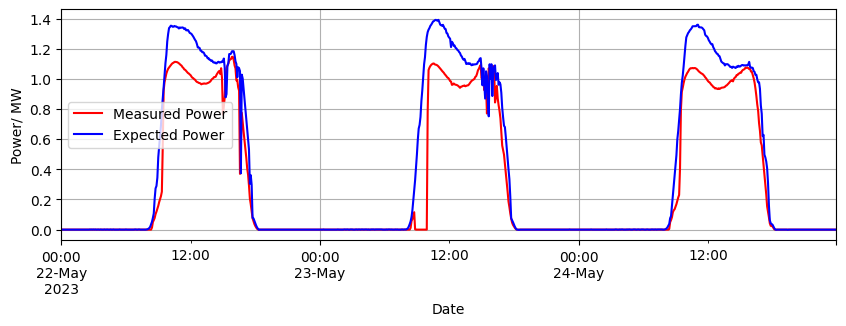

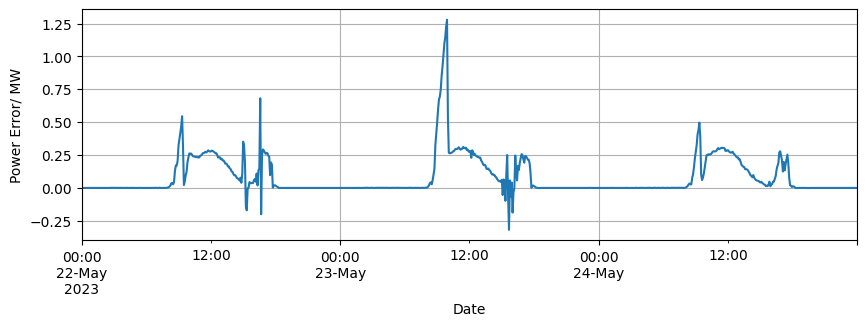

In [7]:
# Define the period you want to plot
start_date = '2023-05-22'
end_date = '2023-05-24'

#start_date = df.index.min()
#end_date = df.index.max()


# Slice the DataFrame based on the specified period
df['shifted_Power'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Measured Power')
df['Power_calculated'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Blue'],label='Expected Power')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


ax = df['Power_error'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3))
plt.ylabel('Power Error/ MW')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [8]:
df.shape

(113472, 7)

In [9]:
df.describe()

,Power,POA,Tmod,Temp,shifted_Power,Power_calculated,Power_error
count,113472.000000,113472.000000,113472.000000,113472.000000,113460.000000,113472.000000,113460.000000
mean,0.296731,233.306539,17.490338,15.354025,0.296762,0.436020,0.139304
std,0.513418,374.776575,16.046519,33.016471,0.513436,0.691944,0.641691
min,0.000000,-1.139593,-6.118014,0.000000,0.000000,-0.002292,-1.700100
25%,0.000000,-0.054264,4.311919,7.100000,0.000000,-0.000116,-0.001209
50%,0.000061,0.000000,13.214670,13.800000,0.000061,0.000000,-0.000113
75%,0.408688,403.147500,28.085210,20.400000,0.408852,0.785646,0.141633
max,1.700452,1502.591000,68.853870,655.260000,1.700452,2.816438,2.816438


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Example: Generate synthetic time series data (replace with your own data loading)
np.random.seed(42)

# Define the period you want to plot
start_date = df.index.min()
end_date = df.index.max()

temp = df[start_date:end_date][['Power','Power_error']].resample('5min').mean()
print(temp.isnull().any().any())
print(np.any(np.isinf(temp)))
print(temp.shape)
temp_cleaned = temp.dropna()
print(temp_cleaned.shape)
data = temp_cleaned.values
print(temp_cleaned.index)


full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='5min')
temp_cleaned_reindexed = temp_cleaned.reindex(full_date_range)

df_ffill = temp_cleaned_reindexed.ffill()

if df_ffill.isnull().values.any():
    df_filled = df_ffill.bfill()
else:
    df_filled = df_ffill

2024-08-01 08:21:22.840089: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 08:21:23.029975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 08:21:25.940827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True
False
(113472, 2)
(113460, 2)
DatetimeIndex(['2023-02-01 00:00:00', '2023-02-01 00:05:00',
               '2023-02-01 00:10:00', '2023-02-01 00:15:00',
               '2023-02-01 00:20:00', '2023-02-01 00:25:00',
               '2023-02-01 00:30:00', '2023-02-01 00:35:00',
               '2023-02-01 00:40:00', '2023-02-01 00:45:00',
               ...
               '2024-02-29 23:10:00', '2024-02-29 23:15:00',
               '2024-02-29 23:20:00', '2024-02-29 23:25:00',
               '2024-02-29 23:30:00', '2024-02-29 23:35:00',
               '2024-02-29 23:40:00', '2024-02-29 23:45:00',
               '2024-02-29 23:50:00', '2024-02-29 23:55:00'],
              dtype='datetime64[ns]', name='time', length=113460, freq=None)


In [11]:
# Normalize data
#scaler = MinMaxScaler()
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

In [13]:
# Create sequences/windows
'''
timesteps = 5 # Length of each sequence/window
num_sequences = len(data_normalized) - timesteps + 1

# Initialize an array to hold the sequences
sequences = np.zeros((num_sequences, timesteps, 1))

for i in range(num_sequences):
    sequences[i] = data_normalized[i:i + timesteps].reshape(-1, 1)

# Print the shape of the resulting three-dimensional array
print("Shape of the sequences array:", sequences.shape)
'''


# Create sequences for LSTM
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:i + timesteps]
        sequences.append(seq)
    return np.array(sequences)


# Train-test split
#X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

# Define the split ratio
train_ratio = 1.0
test_ratio = 0.0
num_train_samples = int(train_ratio * len(data_normalized))

# Split the data
train_data = data_normalized[:num_train_samples]
test_data = data_normalized[num_train_samples:]

train_data_date = temp_cleaned.index[:num_train_samples]
test_data_date = temp_cleaned.index[num_train_samples:]


timesteps = 24  # Example sequence leng|th
train_sequences = create_sequences(train_data, timesteps)
test_sequences = create_sequences(test_data, timesteps)

print("Shape of the train sequences array:", train_sequences.shape)
print("Shape of the test sequences array:", test_sequences.shape)

Shape of the train sequences array: (113436, 24, 2)
Shape of the test sequences array: (0,)


2024-08-01 08:27:43.835758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 1)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 24, 64)               16896     ['input_1[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 32)                   12416     ['lstm[0][0]']                
                                                                                                  
 dense (Dense)               (None, 20)                   660       ['lstm_1[0][0]']              
                                                                                              

/home/ahilan/kernels/default/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1418/1418 [==============================] - 165s 117ms/step - loss: 1.6938 - val_loss: 1.8332
Epoch 8/200
1418/1418 [==============================] - 165s 117ms/step - loss: 1.6802 - val_loss: 1.8214
Epoch 9/200
1418/1418 [==============================] - 165s 117ms/step - loss: 1.6517 - val_loss: 1.8373
Epoch 10/200
1418/1418 [==============================] - 165s 117ms/step - loss: 1.6449 - val_loss: 1.8135
Epoch 11/200
1418/1418 [==============================] - 165s 116ms/step - loss: 1.6352 - val_loss: 1.7885
Epoch 12/200
1418/1418 [==============================] - 165s 117ms/step - loss: 1.6108 - val_loss: 1.8514
Epoch 13/200
 707/1418 [=============>................] - ETA: 1:16 - loss: 1.6055
Epoch 13: saving model to /home/ahilan/gen-research/neoen-site/models/anomaly_detection/power_loss/neoen_one_year_data/model_checkpoint_13.h5
1418/1418 [==============================] - 166s 117ms/step - loss: 1.5986 - val_loss: 1.7430
Epoch 14/200
1418/1418 [=======================

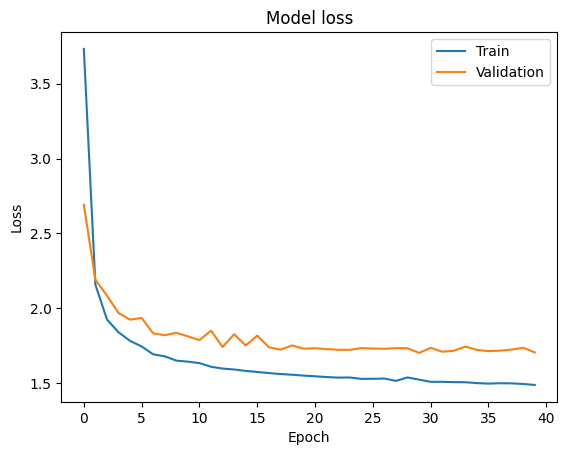

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Function to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Hyperparameters
input_dim = 1   
latent_dim = 20
dropout_rate = 0

# Encoder
inputs = Input(shape=(timesteps, input_dim))
h = LSTM(64, return_sequences=True,dropout=dropout_rate, recurrent_dropout=dropout_rate)(inputs)
h = LSTM(32)(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
#decoder_h1 = Dense(64)
decoder_repeat = RepeatVector(timesteps)
decoder_h2 = LSTM(32, return_sequences=True)
decoder_lstm = LSTM(64, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_output = TimeDistributed(Dense(input_dim))

#z = decoder_h1(z)
h_decoded = decoder_repeat(z)
h_decoded = decoder_h2(h_decoded)
x_decoded_mean = decoder_lstm(h_decoded)
x_decoded_mean = decoder_output(x_decoded_mean)


# VAE model
vae = Model(inputs, x_decoded_mean)

# Loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(x_decoded_mean))
reconstruction_loss *= timesteps * input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 0.10*kl_loss)
vae.add_loss(vae_loss)

batch_size = 64

checkpoint_callback = ModelCheckpoint(
    filepath='/home/ahilan/gen-research/neoen-site/models/anomaly_detection/power_loss/neoen_one_year_data/model_checkpoint_{epoch:02d}.h5',
    save_freq=5 * len(train_sequences) // batch_size,  # Change this to 'batch' to save after every batch
    verbose=1  # Set to 1 for verbose logging, 0 for silent
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', # Monitor the validation loss
    patience=10, # Stop after 10 epochs of no improvement
    verbose=1
)

# Compile model
optimizer = Adam(learning_rate=1e-3)
vae.compile(optimizer=optimizer)
vae.summary()


# Train the VAE with early stopping
#history = vae.fit(train_sequences[:,:,1], epochs=200, batch_size=64, callbacks=[checkpoint_callback])
history = vae.fit(train_sequences[:,:,1], epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping_callback, checkpoint_callback])

# Plot training & validation loss values
#plt.plot(history.history['loss'])
#plt.title('Model loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend(['Train'], loc='upper right')
#plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
#vae = tf.keras.models.load_model('/home/ahilan/gen-research/neoen-site/models/anomaly_detection/power_loss/neoen_one_year_data/model_checkpoint_60.h5')

3545/3545 [==============================] - 56s 15ms/step


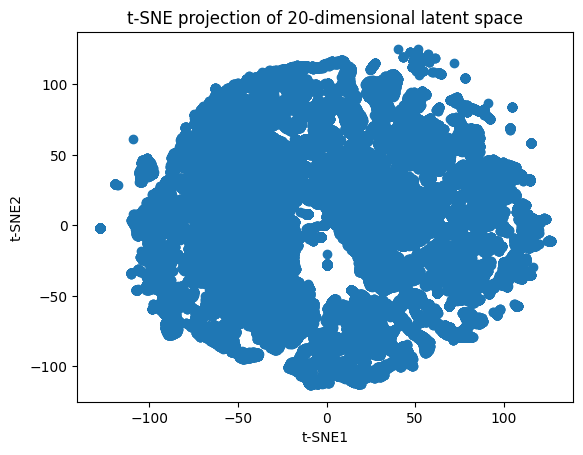

In [15]:
encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(train_sequences[:,:,1])

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(encoded_data)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE projection of 20-dimensional latent space')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()


## Encode and decode some data points
#encoder = Model(inputs, z_mean)
#encoded_data = encoder.predict(train_sequences)

# Display some of the encoded data
#plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
#plt.xlabel("Dimension 1")
#plt.ylabel("Dimension 2")
#plt.title("Encoded Data")
#plt.show()


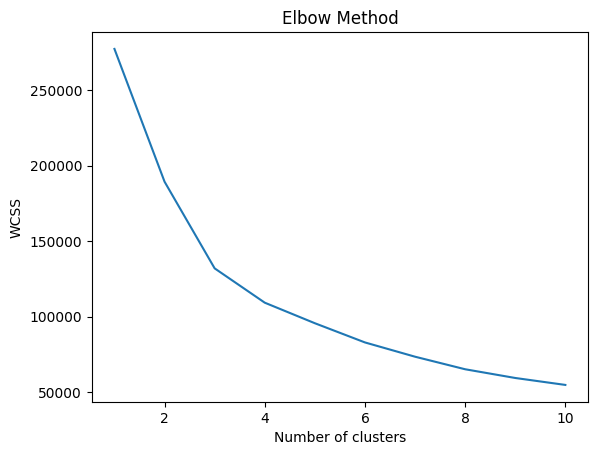

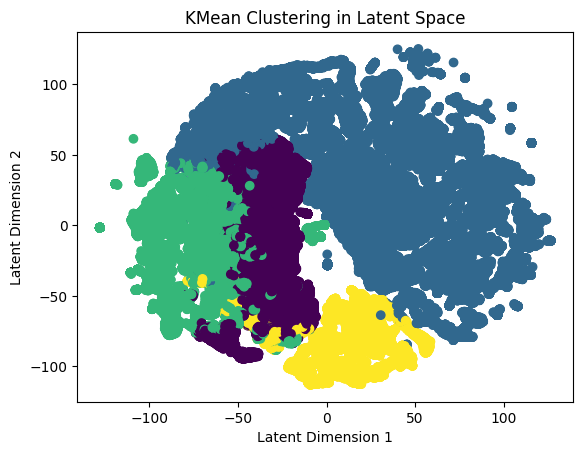

In [16]:
from sklearn.cluster import KMeans
# Determine optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(encoded_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fit K-Means with optimal clusters
np.random.seed(42)
optimal_clusters = 4  # Example
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(encoded_data)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('KMean Clustering in Latent Space')
plt.show()




#from sklearn.mixture import GaussianMixture
# Fit GMM to the latent space
#gmm = GaussianMixture(n_components=4, random_state=0).fit(encoded_data)

# Assign cluster labels and get probabilities
#clusters = gmm.predict(encoded_data)
#probabilities = gmm.predict_proba(encoded_data)

# Visualize the clusters in the latent space (for 2D or 3D latent space)
#plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters)
#plt.xlabel('Latent Dimension 1')
#plt.ylabel('Latent Dimension 2')
#plt.title('GMM Clustering in Latent Space')
#plt.show()

In [4]:
reconstructed_sequences = vae.predict(train_sequences[:,:,1])

NameError: name 'vae' is not defined

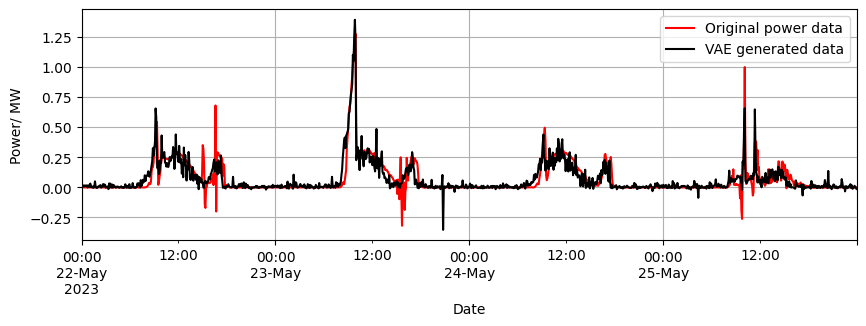

In [18]:
# 1. Reshape sequences back to original form
original_shape = (len(data), 2)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(original_shape)

for i in range(len(train_sequences) - timesteps):
    reconstructed_original_data[i:i + timesteps] = train_sequences[i]
    reconstructed_vae_data[i:i + timesteps] = reconstructed_sequences[i]


X_test_original = scaler.inverse_transform(reconstructed_original_data)
X_test_vae = scaler.inverse_transform(reconstructed_vae_data)

df_orginal = pd.DataFrame(data = X_test_original, index = train_data_date, columns = ['Power','Power_error'])
df_vae_output = pd.DataFrame(data = X_test_vae, index = train_data_date, columns = ['Power','Power_error'])

# Define the period you want to plot
start_date = '2023-05-22'
end_date = '2023-05-25'

# Slice the DataFrame based on the specified period
df_orginal_period = df_orginal[start_date:end_date]
df_vae_output_period = df_vae_output[start_date:end_date]


df_orginal_period['Power_error'].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Original power data')
df_vae_output_period['Power_error'].resample('5min').mean().plot(figsize=(10, 3),color =['Black'],label='VAE generated data')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

(113460, 3)
(113460, 3)
                        Power  Power_error  Clusters
time                                                
2023-02-01 00:00:00  0.000027    -0.000027       1.0
2023-02-01 00:05:00  0.000051    -0.000051       1.0
2023-02-01 00:10:00  0.000092    -0.000092       1.0
2023-02-01 00:15:00  0.000006    -0.000006       1.0
2023-02-01 00:20:00  0.000069    -0.000069       1.0
...                       ...          ...       ...
2024-02-29 23:35:00  0.296762     0.139304       0.0
2024-02-29 23:40:00  0.296762     0.139304       0.0
2024-02-29 23:45:00  0.296762     0.139304       0.0
2024-02-29 23:50:00  0.296762     0.139304       0.0
2024-02-29 23:55:00  0.296762     0.139304       0.0

[113460 rows x 3 columns]


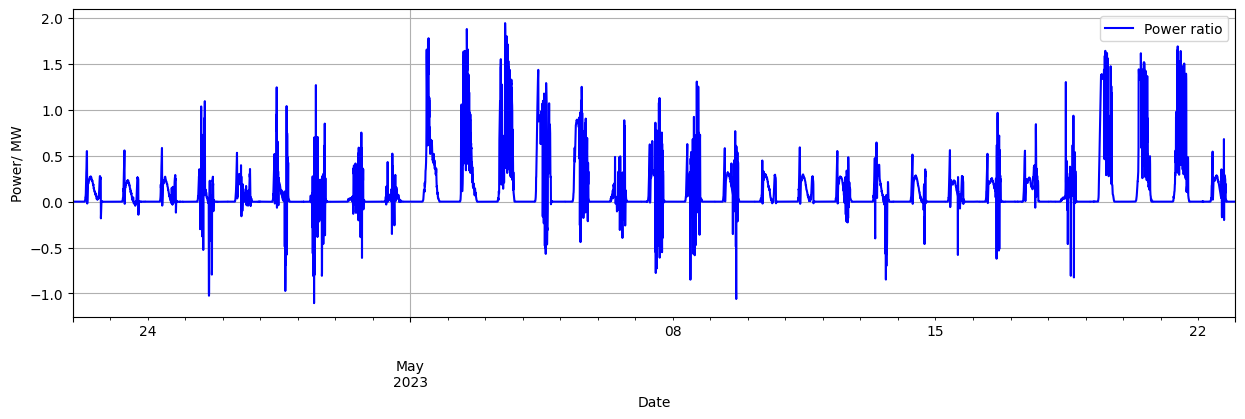

NameError: name 'current_date_str' is not defined

In [28]:
array_b = np.zeros((113436, 24, 1))
reconstructed_sequences_temp = np.concatenate([reconstructed_sequences,array_b], axis=-1) 
reconstructed_sequences_temp[:,:,1] = train_sequences[:,:,1]

# Add cluster labels to the original sequences
clusters_temp = np.repeat(clusters[:, None, None], train_sequences.shape[1], axis=1)
original_sequences_with_clusters = np.concatenate([train_sequences, clusters_temp], axis=-1)
reconstructed_sequences_with_clusters = np.concatenate([reconstructed_sequences_temp, clusters_temp], axis=-1)


# Initialize an array to hold cluster IDs for the entire time series
cluster_ids = np.full(len(train_data), -1)

# Map each sequence's cluster ID back to the corresponding indices in the original time series
for i in range(len(train_sequences)):
    start_idx = i * timesteps
    end_idx = start_idx + timesteps
    cluster_ids[start_idx:end_idx] = clusters[i]

# Ensure that the overlapping indices are smoothed out
def smooth_clusters(cluster_ids, timesteps):
    smoothed_cluster_ids = np.copy(cluster_ids)
    half_window = timesteps // 2

    for i in range(len(cluster_ids) - timesteps):
        window_start = i
        window_end = i + timesteps
        window = cluster_ids[window_start:window_end]
        
        # Use a weighted approach to smooth transitions
        unique, counts = np.unique(window, return_counts=True)
        most_frequent_cluster = unique[np.argmax(counts)]
        
        # Gradual transition using weighted average (or simply assign the most frequent cluster)
        for j in range(window_start, window_end):
            smoothed_cluster_ids[j] = most_frequent_cluster

    return smoothed_cluster_ids

# Apply smoothing
cluster_ids = smooth_clusters(cluster_ids, timesteps)

# Ensure the cluster_ids array has the same length as the original time series
cluster_ids = cluster_ids[:len(train_data)]




'''
# Map each sequence's cluster ID back to the corresponding indices in the original time series
for i in range(len(train_sequences)):
    cluster_ids[i:i+timesteps] = clusters[i]

# Handle the overlapping indices by assigning the most frequent cluster ID within a sliding window
def smooth_clusters(cluster_ids, timesteps):
    smoothed_cluster_ids = np.copy(cluster_ids)
    for i in range(len(cluster_ids) - timesteps + 1):
        window = cluster_ids[i:i + timesteps]
        unique, counts = np.unique(window, return_counts=True)
        most_frequent_cluster = unique[np.argmax(counts)]
        smoothed_cluster_ids[i:i + timesteps] = most_frequent_cluster
    return smoothed_cluster_ids

cluster_ids = smooth_clusters(cluster_ids, timesteps)
print(cluster_ids)
# Ensure the cluster_ids array has the same length as the original time series
cluster_ids = cluster_ids[:len(train_data)]
'''

## Handle the overlapping indices by assigning the most frequent cluster ID
#for i in range(timesteps):
#    unique, counts = np.unique(cluster_ids[i:i+timesteps], return_counts=True)
#    most_frequent_cluster = unique[np.argmax(counts)]
#    cluster_ids[i:i+timesteps] = most_frequent_cluster

## Ensure the cluster_ids array has the same length as the original time series
#cluster_ids = cluster_ids[:len(train_data)]

def plot_time_series_with_clusters(data, cluster_ids, n_clusters):
    plt.figure(figsize=(15, 8))
    for cluster_id in range(n_clusters):
        plt.plot(data[cluster_ids == cluster_id], label=f'Cluster {cluster_id}')
    plt.xlabel('Time')
    plt.ylabel('Normalized Value')
    plt.title('Time Series with Cluster IDs')
    plt.legend()
    plt.show()



# 1. Reshape sequences back to original form
original_shape = (len(train_data), 3)
reconstructed_shape = (len(train_data), 3)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(reconstructed_shape)

for i in range(len(train_sequences) - timesteps):
    reconstructed_original_data[i:i + timesteps] = original_sequences_with_clusters[i]
    reconstructed_vae_data[i:i + timesteps] = reconstructed_sequences_with_clusters[i]


reconstructed_original_data[:,0:2] = scaler.inverse_transform(reconstructed_original_data[:,0:2])
reconstructed_vae_data[:,0:2] = scaler.inverse_transform(reconstructed_vae_data[:,0:2])


df_orginal = pd.DataFrame(data = reconstructed_original_data, index = train_data_date, columns = ['Power','Power_error','Clusters'])
df_vae_output = pd.DataFrame(data = reconstructed_vae_data, index = train_data_date, columns = ['Power_error','Power','Clusters'])

print(df_orginal.shape)
print(df_vae_output.shape)

start_date = '2023-04-22'
end_date = '2023-05-22'

print(df_orginal)
df_orginal['Power_error'][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Blue'],label='Power ratio')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

current_date = '2023-02-22'
end_date = '2023-02-24'
current_date = pd.to_datetime(current_date_str)
end_date = pd.to_datetime(end_date_str)


while current_date <= end_date:
    # Define the three-day interval
    next_date = current_date + pd.Timedelta(days=3)
    print(next_date.strftime('%Y-%m-%d'))

''''    
    # Filter data for the three-day interval
    interval_data = df[current_date.strftime('%Y-%m-%d'):next_date.strftime('%Y-%m-%d')]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(interval_data.index, interval_data['value'], marker='o')
    plt.title(f'Data from {current_date.strftime("%Y-%m-%d")} to {next_date.strftime("%Y-%m-%d")}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()
    
    # Move to the next three-day interval
    current_date = next_date

# Check if clusters exist in the date range
for cluster in range(4):
    cluster_data = df_orginal.query('Clusters == @cluster')[start_date:end_date]
    if not cluster_data.empty:
        cluster_data['Power_error'].resample('5min').mean().plot(
            figsize=(15, 4),
            color=['Red', 'Black', 'Green', 'Pink'][cluster],
            label=f'Cluster {cluster}'
        )


'''
df_orginal['Power_error'][df_orginal['Clusters']==0][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Red'])
df_orginal['Power_error'][df_orginal['Clusters']==1][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Black'])
df_orginal['Power_error'][df_orginal['Clusters']==2][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Green'])
df_orginal['Power_error'][df_orginal['Clusters']==3][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Pink'])
plt.ylabel('Power Ratio')
plt.xlabel('Date')
plt.grid(True)
plt.show()

print(df_orginal)
df_orginal['Power'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Original power data')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

df_orginal['Power'][df_orginal['Clusters']==0][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Red'])
df_orginal['Power'][df_orginal['Clusters']==1][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Black'])
df_orginal['Power'][df_orginal['Clusters']==2][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Green'])
df_orginal['Power'][df_orginal['Clusters']==3][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Pink'])
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.grid(True)
plt.show()
'''

#df_vae_output['Power_error'][df_vae_output['Clusters']==0][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Blue'])
#df_vae_output['Power_error'][df_vae_output['Clusters']==1][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Red'])
#df_vae_output['Power_error'][df_vae_output['Clusters']==2][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Green'])
#df_vae_output['Power_error'][df_vae_output['Clusters']==3][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Black'])
#plt.ylabel('Power/ MW')
#plt.xlabel('Date')
#plt.grid(True)
#plt.show()
'''

'''
print(train_data.shape)
plot_time_series_with_clusters(train_data[:,], cluster_ids, n_clusters)
'''